## Numeric Integration

What does the reaction progress of enzyme kinetics look like over a long stretch of time, far past the initial rate from which we have not yet dared stray? The math is similar to the case of the steady-state kinetic scheme above. However, in the Michaleis-Menten (MM) system, one of the reactants, the enzyme, is present at limiting quanties ($[E]_t \ll [S]_t$) and this case gives rise to the famous MM equation.

$$-\frac{d}{dt}[S] = k_{cat}[E]_t\frac{[S]_t}{K_M+[S]_t}$$

This equation can be integrated analytically using advanced mathematical methods that you will likely never care to learn. I certainly have no clue how to integrate anything but the simplest equations. So, yes, you will never use calculus again in your life but only because others have done the calculus for you already. Understanding the basics of calculus is important if you are to properly stand on the shoulders of mathematicians. The analytical integration was demonstrated in the previous notebook.

In this notebook will not use analytical methods but instead use the numerical algorithms encapsulated the Python tools. We will use `scipy.integration.solve_ivp()`. It will solve a differential equation using numerical methods starting at an "initial value position" (ivp).

## Using *solve_ivp*

The `scipy.integration.solve_ivp()` function will perform a numeric integration of ordinary differential equations. It is simpler to set up than the analytical integration and, in well behaved cases, is very acurate. Let us perform a numerical integration of the MM equation. We can then compare the results with the analytical method.

If we know the value of [S] at a given moment in time then we can easily calculate the rate of change using the above equation. There is only one place where we know the substrate concentration for sure and that is at time zero. So we start there, calculate the rate of change, calculate the change after an infinitesimal amount of time and then start again with the new concentration and repeat endlessly. Obviously there are mathematical approaches to this and they all use various methods to minimize the error caused when the time step used is anything greater than $\frac{1}{\infty}$.

So we know that the numerical approach should be close to the true answer but can never be exact. The analytical method is exact but, as we saw, is difficult with some kinds of equations. The code below defines a function for the rate of change in concentration of substrate according to the MM equation. Then we use `scipy.integration.solve_ivp()` to calculate the concentration of substrate over time using numerical integration methods.

Vmax: 6000.0 uM/min
Km: 0.0050
kcat/Km: 2.00e+04


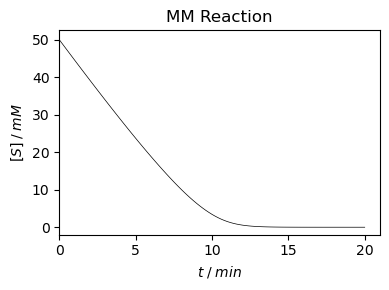

In [7]:
#######################
### import packages ###
#######################

import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

############################################
### Create a function that describes the 
### Michaelis-Menten equation 
############################################

def rates(t, c, E, kcat, Km):
    return -kcat * E * c / (c + Km)

############################################
### Parameters and experimental conditions
############################################

E_conc = 1e-6
KM_value = 0.005          ### set KM value
kcat_value = 1E2          ### set Vmax value
S0_value = .05            ### set initial substrate concentration value

Vmax_value = E_conc * kcat_value
print(f"Vmax: {Vmax_value*1E6*60:0.1f} uM/min")
print(f"Km: {KM_value:0.4f}")
print(f"kcat/Km: {kcat_value/KM_value:0.2e}")

time_end = 1200            ### The end time
n_points = 100            ### number of points - increase if needed


#########################################
### Create series of time points      ###
#########################################

dt = time_end / n_points          ### time step, delta t
t_line = np.arange(0, time_end+dt, dt) ### time vector (list of time points)
num = len(t_line)


##########################
### integrate
##########################

initial = [S0_value]

int = solve_ivp(rates, [0,time_end], 
               initial, 
               method="RK45",   ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
               t_eval=t_line, 
               args=[E_conc,kcat_value,KM_value] 
               )

#########################################
### Extract the results from the returned data object      
#########################################

time = int.t
c = int.y[0]    ### The integrated values come as arrays ins ide the y-array.
                ### If there is only one value then it is still and array in an array


##########################
### plot x and y data
##########################

             ### set x and y values for plot code below
x = time/60     ### convert time from seconds to minutes 
y = c*1000        ### convert conc from M to mM  
 
plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  

ax.plot(x, y,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )
ax.set( xlabel= r"$t\;/\;min$", 
        ylabel=r"$[S] \; / \; mM$",
        title = "MM Reaction",
        xlim=[0, None],                  
        ylim=[-2, None]      
       )


#########################################
### Output the plot
#########################################

fig.tight_layout()         # otherwise the right y-label is slightly clipped

plt.savefig("plot.pdf")     ### export the plot as this
plt.show() 

## Comparing with Anaytical Integration

Below I have stolen the code from the previous notebook to calculate a set of x and y values using the analytical integration. When we are done below we will have a set of numerically integrated substrate concentrations with time (`cc` vs `t` from the code block above) and a set of anaytically calculated concentrations (`c` vs `t`) as calculated in the code block below.  The `t` series will be the same in both data sets.

Then I will plot the difference between the two sets of data. How closely does numerical integration match the truth of analytical integration in this case?



In [8]:
#########################################
### Stolen code to created analytically integrated function for S vs, t
#########################################

import sympy as sym
from matplotlib import pyplot as plt
import numpy as np

##########################
### Set up equation 
##########################

t = sym.symbols('t')           ### create x as a 'symbol', not a variable
Vmax = sym.symbols('V_{max}')  ### create k as a 'symbol'
St = sym.symbols('S_t')        ### create At as a 'symbol'
S0 = sym.symbols('S_0')        ### create A0 as a 'symbol'
KM = sym.symbols('K_M')

xt = sym.Function('x_t')       ### create x as a 'function', not a variable

lhs = sym.Derivative(-St, t)   ### Using Derivative function to get differential of A(t) w.r.t. t
rhs = Vmax*(St/(KM+St))

diffeq = sym.Eq(lhs, rhs)                   ### create a sympy equation
diffeq = diffeq.subs({St: (S0 - xt(t))})    ### Substitute the term with S0-x

##########################
### Solve the differential equation 
##########################

res = sym.dsolve(diffeq, ics={xt(0): 0})    ### Solve the differential equation. Initial condition is x(t) = 0 when t = 0

##########################
### Clean up algebra 
##########################

eq = res.subs(xt(t), S0-St)            ### substitute x for So - St
eq = sym.simplify(eq)                  ### Simplify the result
eq = sym.Eq(eq.lhs - S0, eq.rhs - S0)  ### Subtract S0 from both sides of the equation
eq = sym.Eq(-eq.lhs, -eq.rhs)          ### take the negative of both sides of the equation 

##########################
### Display the final form of equation 
##########################

print("The integrated rate law for the MM equation")
display(eq)                         

##############################################################################

##########################
### create function from equation
##########################

f = sym.lambdify([t, S0, KM, Vmax], eq.rhs)   ### create function in terms of t, S0, KM and Vmax

##########################
### Set up parameters
##########################

E_conc = 1e-6
KM_value = 0.005          ### set KM value
kcat_value = 1E2          ### set Vmax value
S0_value = .05            ### set initial substrate concentration value

Vmax_value = E_conc * kcat_value

time_end = 1200           ### The end time
n_points = 100            ### number of points - increase if needed

xmax = time_end       ### change these as you wish
ymax = S0_value

##########################
### calculate x and y data
##########################
                                                ### t_line comes from the first code block above
s = f(t_line, S0_value, KM_value, Vmax_value)   ### Calculate y according to the function
s = np.real(s)                                  ### the Lambert function produces imaginary numbers. Use on the real component
s = s * 1000

c = y                                           ### numerical results from top code block
diff = 100 * (c - s)/s                          ### % error  

The integrated rate law for the MM equation


Eq(S_t, K_M*LambertW(S_0*exp((S_0 - V_{max}*t)/K_M)/K_M))

## Plot the Difference

Below we will take the `cc` series from the numerical method and the `c` series from the analytical method caluclated at the same time points and plot the difference. As we can see there is no difference. Inspecting the result of the difference calculation reveals a very tiny difference.

We only see errors of any detectable importance when the value of [S] is near zero. very small errors can be large compared to very small numbers. Even in that region, error was less that 3%.

The numerical integration produced the same result as the analytical in this case. And the numerical method was far simpler to set up.

Which would you rather use?

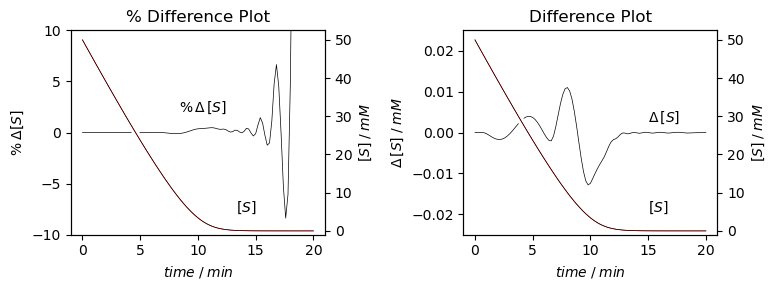

In [12]:
plt.rcdefaults()                    ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))  

ax0 = ax[0]     ### create names for the two axes in the ax array
ax1 = ax[1]

x = t_line/60     ### t_line is time points. Set up in top block of code
y = diff  ### Percent error

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax0.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )

#########################################
### Add more style
#########################################
        

ax0.set(ylabel=r"$\% \; \Delta [S]\; $", 
        xlabel=r"$time\; /\; min$",
        title = "% Difference Plot",
        xlim=[None, None],      
        ylim=[-10, 10])


ax2 = ax0.twinx()

ax2.plot(x, c,
        linestyle = '-',            ### use a line between points
        linewidth='5',              ### make the line thin
        color = 'white',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)
ax2.plot(x, s,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'red',              ### the line is red
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)
ax2.plot(x, c,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0 )                ### everything is in layer 0 (the bottom layer in this case)
 
ax2.text(800/60,0.005*1000,"$[S]$")
ax0.text(500/60, 2.0, "$\%\, \Delta \,[S]$")


ax2.set(ylabel=r"$[S]\; / \;mM$", 
        xlim=[None, None],      
        ylim=[-1, None])


######################################################################################

x = t_line/60
y = (s-c) 

#########################################
### Plot the line using the x_fit, y_fit points
#########################################

ax1.plot(x, y, 
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 1                  ### everything is in layer 0 (the bottom layer in this case)
        )

ax1.text(900/60,0.0025,"$\Delta \,[S]$")

#########################################
### Add more style
#########################################
        
ax1.set(ylabel=r"$\Delta \,[S]\; /\; mM$", 
        xlabel=r"$time\; /\; min$",
        title = "Difference Plot",
        xlim=[None, None],      
        ylim=[-.025, .025])


ax3 = ax1.twinx()

ax3.plot(x, c,
        linestyle = '-',    ### use a line between points
        linewidth='5',      ### make the line thin
        color = 'white',    ### the line is black
        zorder = 3 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.plot(x, s,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'red',      ### the line is black
        zorder = 3 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.plot(x, c,
        linestyle = '-',    ### use a line between points
        linewidth='0.5',    ### make the line thin
        color = 'black',    ### the line is black
        zorder = 3 )        ### everything is in layer 0 (the bottom layer in this case)

ax3.text(900/60, 0.005*1000,"$[S]$")

ax3.set(ylabel=r"$[S]\; / \;mM$", 
        xlim=[None, None],      
        ylim=[-1, None])

##################################################################################

#########################################
### Output the plot
#########################################

fig.tight_layout()  ### otherwise the right y-label is slightly clipped

plt.savefig("plot.pdf")     ### export the plot as this
plt.show()                  ### display the plot in this notebook



## Curve Fitting with Numeric Integration

We have seen in the previous notbook that we can fit data to the function created from the analytical integration of the Michaelis-Menten equation. Can we do the same with numeric integration? Yes we can.

We will need to create a function that performs the numeric integration using parameters fed into it by the `curve_fit()` function. The `curve_fit()` function will optimize the parameters until the best fit with the data is reached. Beware that numeric integration can occassionally take some time. So be sure to use a method that is quick. Or go get a coffee while your calculation runs.

Take note that we are fitting for the parameters $V_{max}$ and $K_M$. I cannot curve fit to optimize values for $[E]$ and $k_{cat}$ instead of $V_{max}$. These two terms combine to give $V_{max}$ and the curve fit would choose any pair of values that combined to give the result of $V_{max} = [E]\cdot k_{cat}$ (The algorithm would likely fail to converge to an answer in this case). We must know the concentration of enzyme to obtain $k_{cat}$ from $V_{max}$ after the curve fit.



Vmax: 5.28 +/- 0.10
Km: 1.48 +/- 0.05


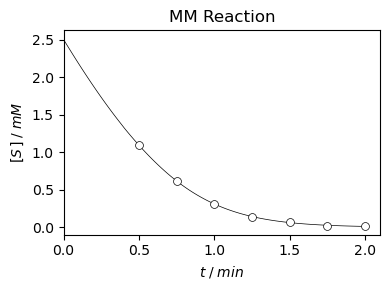

In [11]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

init_S_conc = 2.5

time = np.array([30, 45, 60, 75, 90, 105, 120])  ### the time points(every 15 seconds)
time = time/60                                       ### convert to minutes

conc = [1.09, 0.62, 0.31, 0.14, 0.065, 0.019, 0.016]   ### measured concentration of substrate (less error)
#conc = [1.10, 0.62, 0.31, 0.15, 0.062, 0.042, 0.014]   ### measured concentration of substrate (more error)
#conc = [1.15, 0.61, 0.33, 0.17, 0.052, 0.081, 0.021]   ### measured concentration of substrate (even more error)


def fitfunc(t, Vmax, Km):
    'Function that returns Ca computed from an ODE for a k'

    def rates(t, c, Vmax, Km):
        return -Vmax * c / (c + Km)

    initial = [init_S_conc]

    int = solve_ivp(rates, [0,np.max(time)], 
                   initial, 
                   method="LSODA",   ### 'RK45', 'RK23', 'LSODA', 'DOP853', 'Radau', 'BDF'
                   t_eval=t, 
                   args=[Vmax, Km] 
                   )

    yarray = int.y[0]

    return yarray

k_fit, pcov = curve_fit(fitfunc, time, conc)

perr = np.sqrt(np.diag(pcov))

Vmax, Km = k_fit
Vmax_stdev, Km_stdev = perr

print(f"Vmax: {Vmax:0.2f} +/- {Vmax_stdev:0.2f}")
print(f"Km: {Km:0.2f} +/- {Km_stdev:0.2f}")

##########################
### plot x and y data
##########################

x = time      ### The data that was used in the curve fit 
y = conc      ### convert conc from M to mM  

x_fit = np.linspace(0,np.max(time),100);   ### The line calucltade from the optimized parameters
y_fit = fitfunc(x_fit, Vmax, Km)

plt.rcdefaults()     ### resets the plot defaults so we always start in the same place
#plt.style.use("../styles/tufte.mplstyle")     ### Then add a fancy style sheet   

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))  

ax.plot(x_fit, y_fit,
        linestyle = '-',            ### use a line between points
        linewidth='0.5',            ### make the line thin
        color = 'black',            ### the line is black
        zorder = 0                  ### everything is in layer 0 (the bottom layer in this case)
        )
ax.scatter(x, y, 
        marker='o',                 ### Plot the x and y data 
        color='white',              ### markers are this color
        edgecolors = 'black',       ### outline of markers is this color
        linewidths = 0.5,           ### outline of markers is this wide
        s=32,                       ### "s" is "size". sqrt(64) = 8 points wide
        zorder = 2                  ### everything is in layer 1 (the top layer in this case)
        )
ax.set( xlabel= r"$t\;/\;min$", 
        ylabel=r"$[S\,] \; / \; mM$",
        title = "MM Reaction",
        xlim=[0, None],                  
        ylim=[-0.1, None]      
       )
#ax.spines[['left','bottom']].set_position(('axes',-0.05))   ### space spines a little away from 'axes' (plot box)


#########################################
### Output the plot
#########################################

fig.tight_layout()         # otherwise the right y-label is slightly clipped

plt.savefig("plot.pdf")     ### export the plot as this
plt.show() 